In [1]:
from sklearn.datasets import fetch_mldata
from sklearn.datasets import fetch_olivetti_faces

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from sklearn.datasets import make_regression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from ipywidgets import interactive
import ipywidgets as widgets

from sklearn.model_selection import train_test_split

# Unsupervised Learning, Part 2: Dimensionality Reduction

## Principal Component Analysis

First, let's revisit the MNIST data:

In [71]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

/opt/anaconda3/envs/jh/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/opt/anaconda3/envs/jh/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [72]:
mnist.data.shape

(70000, 784)

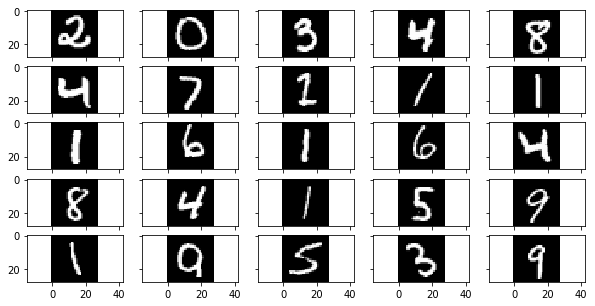

In [84]:
# Let us visualize a few random images from the dataset
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.figure(figsize = (5,5))

fig, axs = plt.subplots(5, 5, sharex=True, sharey=True, figsize = (10,5))
for i in range(5):
    for j in range(5):
        axs[i, j].imshow(mnist.data[np.random.randint(mnist.data.shape[0])].reshape((28,28)),cmap = plt.cm.gray)
                         
plt.show()

It looks like most of the data is somewhere in the middle, whereas the borders of the images are usually black. Let's analyze the data further by computing the variance of each pixel across all images:

In [74]:
s = np.std(mnist.data, axis = 0, keepdims = True).reshape([28,28])

In [75]:
# first row:
s[0,:]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.44006125,  1.26020885,  0.81639743,
        0.03401656,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ])

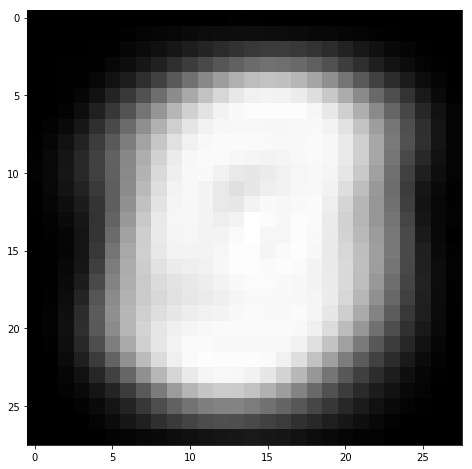

In [76]:
plt.figure(figsize = (8,8))
plt.imshow(s, cmap = plt.cm.gray)
plt.show()

In [78]:
# how many pixels do not change at all?
np.sum(s == 0)

65

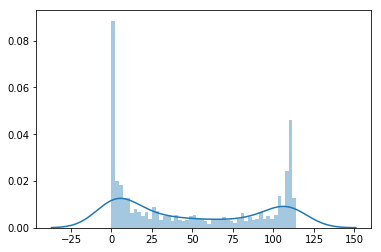

In [82]:
# let us see the distribution of pixels that change and their values:
import seaborn as sns

sns.distplot(s.reshape(-1), bins = 50)

What does this mean to us? Even though the space has 784 dimensions, there are many dimensions (pixels) that do not contain too much information about the data. 

Moreover, the dimensions are not necessarily orthogonal, meaning that the pixel values are not independent of each other. 

In [77]:
mnist.data.shape

(70000, 784)

Let us pick 10x10 pixel square at the center of the images and find correlations between pixels

In [80]:
cc = np.corrcoef(mnist.data.reshape([-1,28,28])[:,10:20,10:20].reshape([-1,10*10]),rowvar = False)
cc.shape

(100, 100)

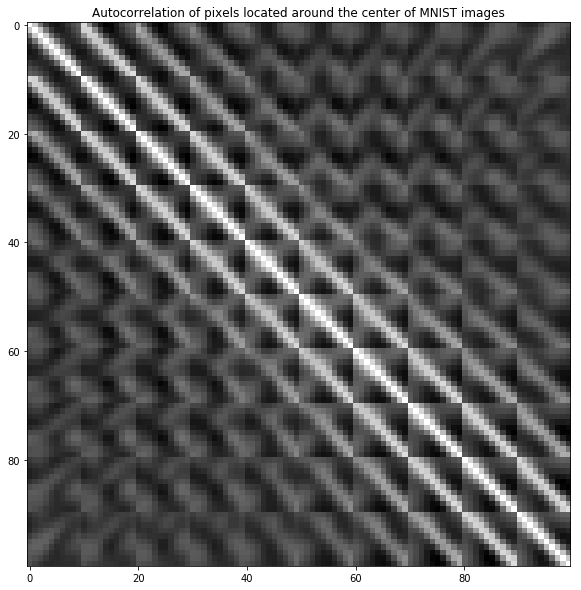

In [90]:
plt.figure(figsize = (10,10))
plt.imshow(cc, cmap = plt.cm.gray)
plt.title('Autocorrelation of pixels located around the center of MNIST images')
plt.show()

# Principal Component Analysis (PCA)

Suppose 2D data is as shown in the image below. The horizontal and vertical axis are the feature of the data. The idea behind PCA is to add a new axis that captures the highest variance of the data. PCA can add more axis to the data, but it will keep them orthogonal to each other.
![](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f5/GaussianScatterPCA.svg/1200px-GaussianScatterPCA.svg.png)

Let us illustrate this on a synthetic data example:

In [120]:
i = np.arange(0,10,0.1)
np.random.seed(1)
X = np.asarray([i,i]).T+np.random.normal(0,1,X.shape)
X.shape

(100, 2)

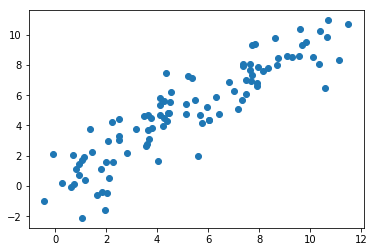

In [121]:
plt.figure()
plt.scatter(X[:,0],X[:,1])
plt.show()

In [122]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
tX = pca.fit_transform(X)

In [123]:
pca.explained_variance_ratio_, pca.singular_values_

(array([ 0.95226717]), array([ 43.03302258]))

In [124]:
X_restored = pca.inverse_transform(tX)


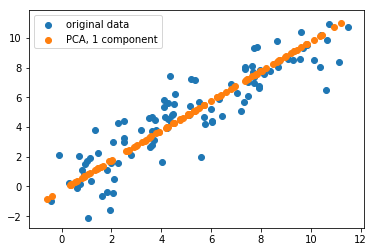

In [125]:
plt.figure()
plt.scatter(X[:,0],X[:,1], label = 'original data')
plt.scatter(X_restored[:,0],X_restored[:,1], label = 'PCA, 1 component')
plt.legend()
plt.show()

## PCA on MNIST data

In [96]:
pca = PCA(n_components = 2).fit(mnist.data)

In [97]:
pca.explained_variance_ratio_ # as we can see from here, 2 components is not enough

array([ 0.09746116,  0.07155445])

In [106]:
pca = PCA(n_components = 10).fit(mnist.data)

In [107]:
pca.explained_variance_ratio_

array([ 0.09746116,  0.07155445,  0.06149531,  0.05403385,  0.04888934,
        0.04305227,  0.03278261,  0.02889641,  0.02758363,  0.02342133])

In [108]:
# total explained variance:
np.sum(pca.explained_variance_ratio_)

0.48917035396564262

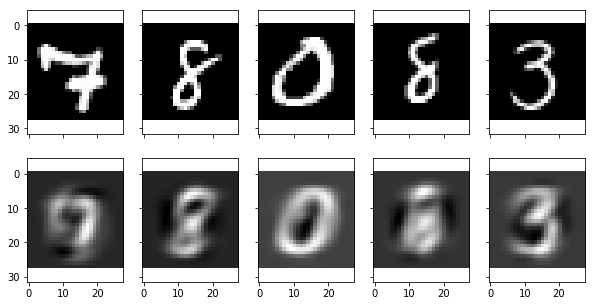

In [109]:
# what do the images look like?

fig, axs = plt.subplots(2, 5, sharex=True, sharey=True, figsize = (10,5))
for i in range(5):
    #for j in range(5):
    idx = np.random.randint(mnist.data.shape[0])
    axs[0, i].imshow(mnist.data[idx].reshape((28,28)),cmap = plt.cm.gray)
    transformed_data = pca.transform(mnist.data[idx].reshape([1,-1]))
    restored_data = pca.inverse_transform(transformed_data)
    axs[1, i].imshow(restored_data.reshape((28,28)),cmap = plt.cm.gray)                     
plt.show()

Now, let us see how many components do we need to explain 95% of variance?

In [110]:
pca = PCA().fit(mnist.data) # do not specify the number of components, use everything

In [111]:
var_explained = np.cumsum(pca.explained_variance_ratio_)
var_explained[:5]

array([ 0.09746116,  0.16901561,  0.23051091,  0.28454476,  0.3334341 ])

In [112]:
# what is the minimum number of components that explain 95% of variance?
np.argmax(var_explained > 0.95) # np.argmax will stop at the first True

153

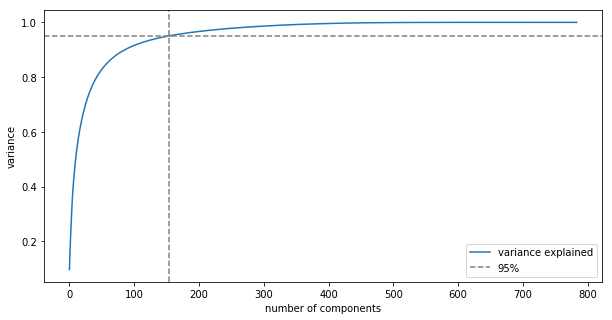

In [113]:
plt.figure(figsize = (10,5))
plt.plot(var_explained, label = 'variance explained')
plt.xlabel('number of components')
plt.ylabel('variance')
plt.axhline(y = 0.95, linestyle='--', color = 'gray', label = '95%')
plt.axvline(x = 153, linestyle='--', color = 'gray')
plt.legend()
plt.show()

In [194]:
pca = PCA(n_components = 153).fit(mnist.data)

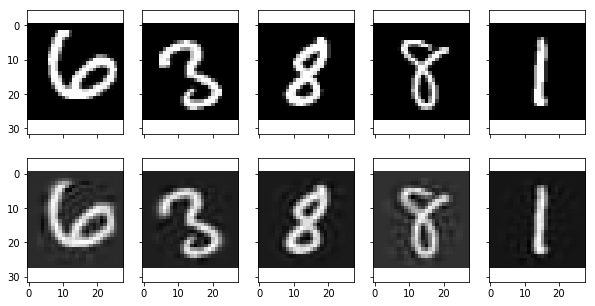

In [195]:
# what do the images look like?

fig, axs = plt.subplots(2, 5, sharex=True, sharey=True, figsize = (10,5))
for i in range(5):
    idx = np.random.randint(mnist.data.shape[0])
    axs[0, i].imshow(mnist.data[idx].reshape((28,28)),cmap = plt.cm.gray)
    transformed_data = pca.transform(mnist.data[idx].reshape([1,-1]))
    restored_data = pca.inverse_transform(transformed_data)
    axs[1, i].imshow(restored_data.reshape((28,28)),cmap = plt.cm.gray)                     
plt.show()

## Clustering on PCA data

### Performance comparison

We can find the number of components to account for 99% of variance. The transformed data will be practically identical to the original data, but in a much more compact form. Let us compare performance of KMeans clustering algorithm on the original MNIST vs PCA MNIST:

In [169]:
# how many components to account for 99% of variance?
np.argmax(var_explained > 0.99)

13

In [170]:
# let's reduce the dimensionality and run clustering
X = PCA(n_components = 153).fit_transform(mnist.data)

X_train, X_test, y_train, y_test = train_test_split(X, mnist.target, test_size=0.99, random_state=0)

%timeit KMeans(n_clusters = 10, random_state = 0).fit(X_train)

699 ms ± 271 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [171]:
# KMeans without PCA:
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.99, random_state=0)
%timeit KMeans(n_clusters = 10, random_state = 0).fit(X_train)

1.69 s ± 223 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


It is 696 milliseconds for PCA KMeans vs. 1.56 seconds with original data. Now, let us use 95% of explained variance and run KMeans clustering on the data. This is the same task as before, but we can now run it on more data.

In [158]:
pca = PCA(n_components = 153) # 95% of variance
X = pca.fit_transform(mnist.data)
X_train, X_test, y_train, y_test = train_test_split(X, mnist.target, test_size=0.9, random_state=0)
kmeans = KMeans(n_clusters = 25, random_state = 0).fit(X_train)
y_pred = kmeans.predict(X_train)

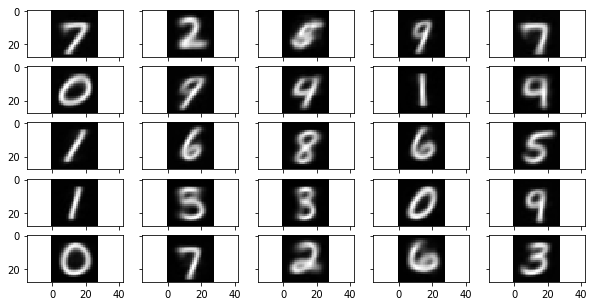

In [159]:
fig, axs = plt.subplots(5, 5, sharex=True, sharey=True, figsize = (10,5))
for i in range(5):
    for j in range(5):
        im_data = pca.inverse_transform(X_train[y_pred == i*5+j])
        axs[i, j].imshow(im_data.mean(axis = 0).reshape([28,28]), cmap = plt.cm.gray)

## The Olivetti faces dataset

The dataset contain 400 photos of 39 people (roughly 10 photos/person). Eeach photo is 64x64 pixels. More on the dataset is available here: https://scikit-learn.org/0.19/datasets/olivetti_faces.html


In [2]:
of = fetch_olivetti_faces()
of.data.shape

(400, 4096)

First, let us display 25 random faces from the dataset:

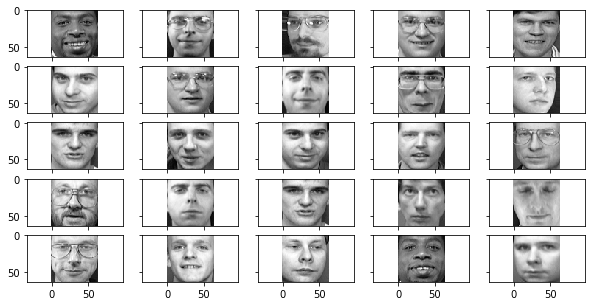

In [3]:
fig, axs = plt.subplots(5, 5, sharex=True, sharey=True, figsize = (10,5))
for i in range(5):
    for j in range(5):
        idx = np.random.randint(of.data.shape[0])
        axs[i, j].imshow(of.data[idx].reshape([64,64]), cmap = plt.cm.gray)

Let us apply PCA with and see how much information we can retain based on the number of principal components:

In [175]:
pca = PCA(n_components = 10)
X = pca.fit_transform(of.data)
rest_X = pca.inverse_transform(X)

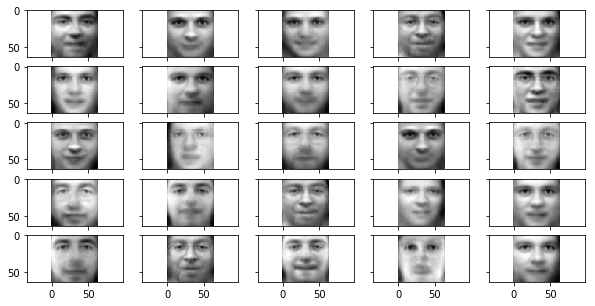

In [176]:
fig, axs = plt.subplots(5, 5, sharex=True, sharey=True, figsize = (10,5))
for i in range(5):
    for j in range(5):
        idx = np.random.randint(of.data.shape[0])
        axs[i, j].imshow(rest_X[idx].reshape([64,64]), cmap = plt.cm.gray)

What if we go to the extreme case and keep only _one_ principal component?

In [177]:
pca = PCA(n_components = 1)
X = pca.fit_transform(of.data)
X[:5]

array([[-6.43261528],
       [-1.07588398],
       [-5.29294682],
       [-4.25359154],
       [-3.96200132]], dtype=float32)

Each face is now described by a single scalar number. Let us explore the range:

In [131]:
np.min(X), np.max(X)

(-10.960077, 11.343952)

We can now `create' faces by changing that number:

In [141]:
new_faces = np.arange(np.min(X), np.max(X)+1).reshape([-1,1])
new_faces_restored = pca.inverse_transform(new_faces)
new_faces_restored.shape

(24, 4096)

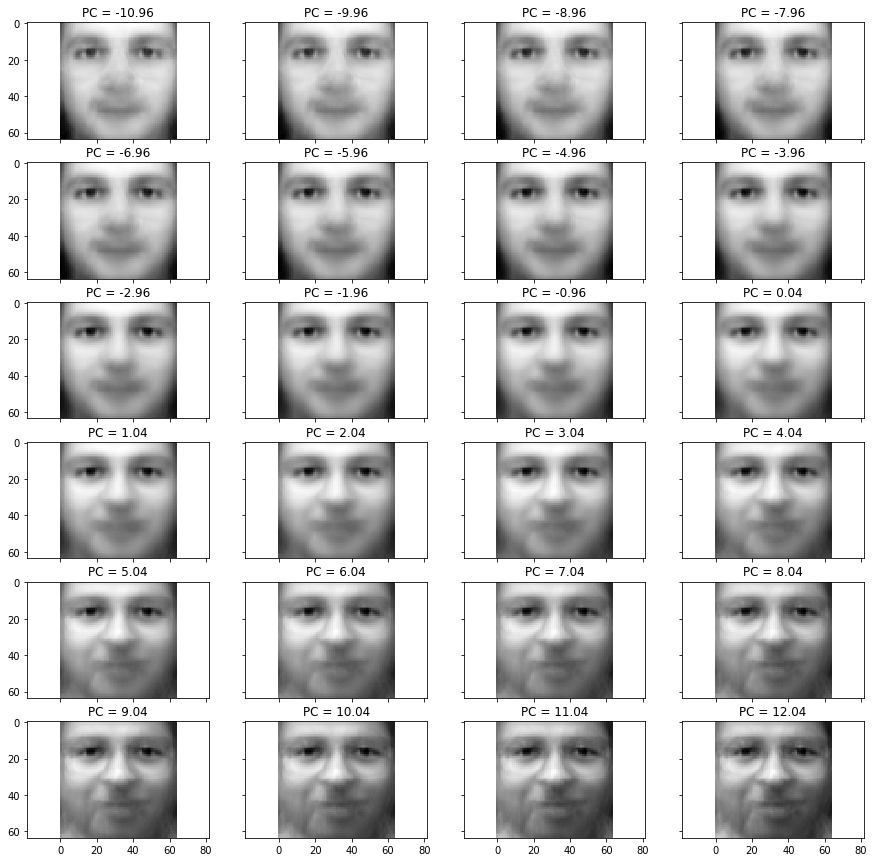

In [178]:
fig, axs = plt.subplots(6, 4, sharex=True, sharey=True, figsize = (15,15))
for i in range(6):
    for j in range(4):
        axs[i, j].imshow(new_faces_restored[i*4+j].reshape([64,64]), cmap = plt.cm.gray)
        axs[i,j].set_title('PC = %.2f'%new_faces[i*4+j])
plt.show()

... or we can play with the first 5 principal components and see what they do:

In [179]:
pca = PCA(n_components = 5)
X = pca.fit_transform(of.data)

def show_face(p1,p2,p3,p4,p5):
    plt.figure(figsize = (5,5))
    ax = plt.subplot(111)
    face = pca.inverse_transform(np.asarray([[p1,p2,p3,p4,p5]]))
    ax.imshow(face.reshape([64,64]), cmap = plt.cm.gray)
    #plt.show()
    
plot = interactive(show_face
                   , p1 = (-15,15,0.1)
                   , p2 = (-15,15,0.1)
                   , p3 = (-15,15,0.1)
                   , p4 = (-15,15,0.1)
                   , p5 = (-15,15,0.1))
plot

interactive(children=(FloatSlider(value=0.0, description='p1', max=15.0, min=-15.0), FloatSlider(value=0.0, de…

### Apply PCA and clustering to Olivetti

Questions to consider:
1. How many PCA components do you need? Find the balance between speed and quality
2. How many clusters do you need?
3. Visualize the clusters

In [ ]:
# your code is here....

## President Putin Elections, Russia 2018

In [1]:
import pandas as pd
df = pd.read_csv('./data/uiks-utf8.csv')#.drop(['region_name','tik_name','uik_name'], axis = 1)
df.head()

,region_name,tik_name,uik_name,registered_voters,received_ballots,early_voting_ballots,onsite_ballots,offsite_ballots,unused_ballots,found_offsite_ballots,...,lost_ballots,unaccounted_ballots,baburin,grudinin,zhirinovsky,putin,sobchak,suraykin,titov,yavlinsky
0,98 Город Байконур (Республика Казахстан),98 Город Байконур (Республика Казахстан),УИК №8140,2132,2000,0,1447,11,542,11,...,0,0,4,176,79,1136,30,9,5,10
1,98 Город Байконур (Республика Казахстан),98 Город Байконур (Республика Казахстан),УИК №8141,2207,2000,0,1470,14,516,14,...,0,0,2,128,87,1214,19,4,7,9
2,98 Город Байконур (Республика Казахстан),98 Город Байконур (Республика Казахстан),УИК №8142,2249,2000,0,1490,7,503,7,...,0,0,5,171,94,1162,17,3,12,6
3,98 Город Байконур (Республика Казахстан),98 Город Байконур (Республика Казахстан),УИК №8143,1769,1500,0,1065,48,387,48,...,0,0,5,98,72,882,17,8,5,6
4,98 Город Байконур (Республика Казахстан),98 Город Байконур (Республика Казахстан),УИК №8144,1880,1500,0,1171,13,316,13,...,0,0,7,124,105,902,7,9,10,10


In [3]:
df_region_name = pd.read_csv('./data/uiks-utf8.csv')['region_name']
num_cols = ['registered_voters','valid_ballots','baburin','grudinin','zhirinovsky','putin',
        'sobchak','suraykin','titov','yavlinsky']
df = pd.read_csv('./data/uiks-utf8.csv')[num_cols]
df = df.div(df['registered_voters'], axis = 0).drop(['registered_voters'], axis = 1).dropna()

In [90]:
df.head()

,valid_ballots,baburin,grudinin,zhirinovsky,putin,sobchak,suraykin,titov,yavlinsky
0,0.679644,0.001876,0.082552,0.037054,0.532833,0.014071,0.004221,0.002345,0.004690
1,0.666063,0.000906,0.057997,0.039420,0.550068,0.008609,0.001812,0.003172,0.004078
2,0.653624,0.002223,0.076034,0.041796,0.516674,0.007559,0.001334,0.005336,0.002668
3,0.617863,0.002826,0.055399,0.040701,0.498587,0.009610,0.004522,0.002826,0.003392
4,0.624468,0.003723,0.065957,0.055851,0.479787,0.003723,0.004787,0.005319,0.005319


In [161]:
df = pd.read_csv('./data/uiks-utf8.csv').drop(['region_name','tik_name','uik_name'], axis = 1)
df = df.div(df['registered_voters'], axis = 0).drop(['registered_voters'], axis = 1).dropna()
df.head()

,received_ballots,early_voting_ballots,onsite_ballots,offsite_ballots,unused_ballots,found_offsite_ballots,found_onsite_ballots,invalid_ballots,valid_ballots,lost_ballots,unaccounted_ballots,baburin,grudinin,zhirinovsky,putin,sobchak,suraykin,titov,yavlinsky
0,0.938086,0.0,0.678705,0.005159,0.254221,0.005159,0.678705,0.004221,0.679644,0.0,0.0,0.001876,0.082552,0.037054,0.532833,0.014071,0.004221,0.002345,0.004690
1,0.906208,0.0,0.666063,0.006343,0.233802,0.006343,0.666063,0.006343,0.666063,0.0,0.0,0.000906,0.057997,0.039420,0.550068,0.008609,0.001812,0.003172,0.004078
2,0.889284,0.0,0.662517,0.003112,0.223655,0.003112,0.662517,0.012005,0.653624,0.0,0.0,0.002223,0.076034,0.041796,0.516674,0.007559,0.001334,0.005336,0.002668
3,0.847937,0.0,0.602035,0.027134,0.218768,0.027134,0.602035,0.011306,0.617863,0.0,0.0,0.002826,0.055399,0.040701,0.498587,0.009610,0.004522,0.002826,0.003392
4,0.797872,0.0,0.622872,0.006915,0.168085,0.006915,0.622872,0.005319,0.624468,0.0,0.0,0.003723,0.065957,0.055851,0.479787,0.003723,0.004787,0.005319,0.005319


In [162]:
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(df)

Let us apply PCA and see how many components we need:

In [163]:
pca = PCA().fit(X)
var_explained = np.cumsum(pca.explained_variance_ratio_)
var_explained[:15]

array([ 0.19115291,  0.33134589,  0.4394454 ,  0.53362904,  0.62086821,
        0.68880889,  0.74292617,  0.79296054,  0.83973897,  0.88412485,
        0.9274034 ,  0.96137902,  0.98191388,  0.99997673,  0.99999718])

It looks like we do not need 2 features, b/c these features are linearly dependent:
* The number of all ballots (early voting, onsite, etc.) must add up to match received ballots
* The number of votes for each candidate must add up to match valid ballots (contrary to some mass media insinuations)

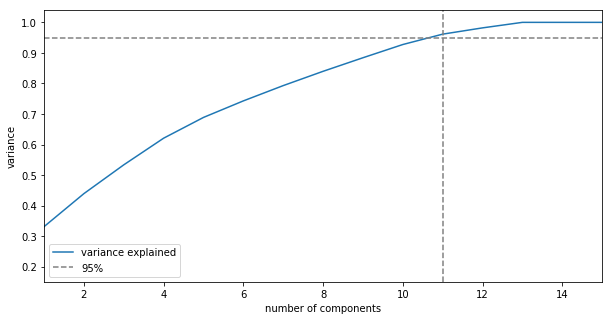

In [165]:
plt.figure(figsize = (10,5))
plt.plot(var_explained, label = 'variance explained')
plt.xlabel('number of components')
plt.ylabel('variance')
plt.axhline(y = 0.95, linestyle='--', color = 'gray', label = '95%')
plt.axvline(x = 11, linestyle='--', color = 'gray')
plt.xlim([1,15])
plt.legend()
plt.show()

It looks like we need 11 components to account for 95% variance in the data. However, even 5 components account for ~60%. Let us visualize the first two components:

In [166]:
pca = PCA(n_components = 2).fit(X)
pca_X = pca.transform(X)

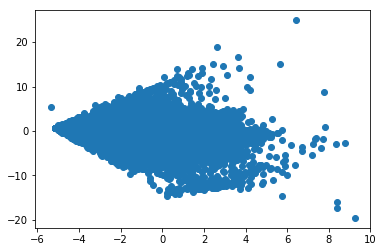

In [167]:
plt.figure()
plt.scatter(pca_X[:,0],pca_X[:,1])
plt.show()

### Clustering on PCA data

In [168]:
pca = PCA(n_components = 6, random_state = 1).fit(X) # Choose 6 components to preserve 70% of the variance
pca_X = pca.transform(X)
kmm = KMeans(n_clusters = 5, random_state = 1).fit(pca_X) # let us pick 5 clusters because it is easier to explain them

In [107]:
df['cluster'] = kmm.labels_
df.groupby('cluster').mean().sort_values(by = 'valid_ballots')

,valid_ballots,baburin,grudinin,zhirinovsky,putin,sobchak,suraykin,titov,yavlinsky
cluster,,,,,,,,,
3,0.598390,0.003866,0.077570,0.042317,0.455028,0.007723,0.004064,0.003668,0.004155
0,0.662315,0.006275,0.077441,0.034742,0.484056,0.026257,0.004697,0.010542,0.018304
1,0.788026,0.005360,0.116763,0.067184,0.579108,0.008023,0.005316,0.003345,0.002927
2,0.861794,0.011310,0.081479,0.057225,0.639479,0.011234,0.044912,0.009674,0.006480
4,0.889072,0.002615,0.045870,0.027153,0.801534,0.004594,0.003148,0.002109,0.002049


What are the clusters?

* 0 -- 'Sobchak', 'Titov', 'Yavlinsky' cluster, turnout ~66%
* 1 -- 'Grudinin'&'Zhirinovsky' cluster, turnout ~79%
* 2 -- 'Baburin'&'Suraykin' cluster, turnout ~86%
* 3 -- smallest turnout, only ~60%
* 4 -- 'Putin' anomaly cluster (80% votes for Putin), turnout of ~89%

Let us see by geography. What parts had the lowest turnout (cluster 3)?

In [121]:
df['region_name'] = df_region_name # add names to the dataframe

def get_top_regions(cluster_no, limit = 5):
    return df[df.cluster == cluster_no].groupby('region_name').count().reset_index()\
            .sort_values(by='cluster', ascending = False)[['region_name','valid_ballots']].head(limit)

get_top_regions(3)

,region_name,valid_ballots
31,Московская область,2794
65,Свердловская область,1762
15,Иркутская область,1721
60,Ростовская область,1577
25,Красноярский край,1443


In [123]:
# who voted for Sobchak, Titov, and Yavlinsky? These are 'liberals'
get_top_regions(0)

,region_name,valid_ballots
82,город Москва,2996
83,город Санкт-Петербург,1767
30,Московская область,994
65,Свердловская область,459
77,Челябинская область,369


In [125]:
# how about Grudinin and Zhirinovsky? These Grudinin -- communist, Zhirinovsky -- ???
get_top_regions(1)

,region_name,valid_ballots
44,Республика Башкортостан,1076
1,Алтайский край,1022
36,Оренбургская область,621
75,Челябинская область,534
54,Республика Саха (Якутия),496


In [127]:
# how about Baburin and Suraykin? These are the clear outliers
get_top_regions(2)

,region_name,valid_ballots
41,Республика Татарстан (Татарстан),209
40,Республика Северная Осетия - Алания,93
34,Республика Башкортостан,71
47,Сахалинская область,29
24,Мурманская область,24


In [129]:
# Putin's outlier
get_top_regions(4)

,region_name,valid_ballots
57,Республика Татарстан (Татарстан),1734
47,Республика Дагестан,1600
45,Республика Башкортостан,1376
23,Краснодарский край,1336
20,Кемеровская область,1298


# Appendix: How Principal Component Analysis Work

Suppose that we deal with Olivetti faces, where the data is a table with 400 rows and 4096 columns:

In [38]:
of = fetch_olivetti_faces()
of.data.shape

(400, 4096)

The first step of PCA is to compute the covariance matrix, or the matrix of correlations between each column of the data. In application to Olivetti faces, these are the pixels. Let us first investigate what is the relationship between two neighboring pixels in the top left corner of the images:

In [5]:
col1 = of.data[:,0] # this is column 0, or left top pixel
col2 = of.data[:,1] # this is column 1, or pixel right next to left top

As seen in the figure below, there is a clear relationship:

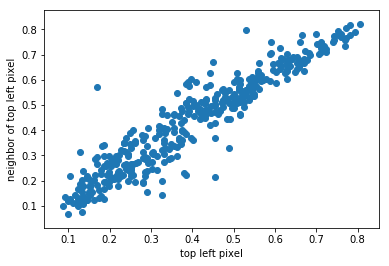

In [126]:
plt.figure()
plt.scatter(col1,col2)
plt.xlabel('top left pixel')
plt.ylabel('neighbor of top left pixel')
plt.show()

Can we quantify this relationship? This will require a two-step procedure. At first step, we normalize the values of each pixel $p$ according to the formula:

$Z_p = \frac{P - \mu_p}{\sigma_p}$

where $\mu_p$ and $\sigma_p$ are $p$'s mean and standard deviations.

At the next step we will compute the average product of two normalized pixel values:

$cc = \frac{1}{N}\left(Z_{p_1} \cdot Z_{p_2}\right)$

So, let's first find the normalized values:

In [39]:
z_col1 = (col1 - np.mean(col1))/np.std(col1)
z_col2 = (col2 - np.mean(col2))/np.std(col2)

Let us make sure that the dependency between the two has not changed:

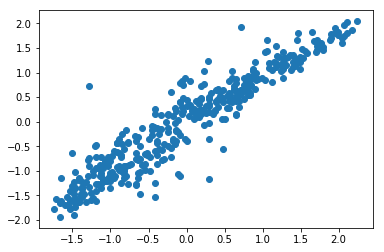

In [40]:
plt.figure()
plt.scatter(z_col1,z_col2)
plt.show()

The average of the product is also known as the *correlation coefficient*:

In [9]:
# Pearson correlation coefficient between col1 and col2 will be the average of the product of z_col1 by z_col2:
cc = np.mean(z_col1*z_col2)
cc

0.9432174

Correlation coefficient can also be computed with NumPy:

In [43]:
# Let us double check this by running NumPy's function:
np.corrcoef(of.data[:,0],of.data[:,1])

array([[ 1.       ,  0.9432174],
       [ 0.9432174,  1.       ]])

Let us generalize the approach above and compute the correlation between every two pixels in the image and put the results into *covariance matrix*. No surprise that the matrix is square and its size matches the number of pixels.

In [44]:
cov_matrix = np.corrcoef(of.data.T) 
cov_matrix.shape

(4096, 4096)

In [12]:
# the covariance matrix contains all possible correlations between pixels:
cov_matrix[:5,:5]

array([[ 1.        ,  0.9432174 ,  0.81486848,  0.70258154,  0.60922353],
       [ 0.9432174 ,  1.        ,  0.92443031,  0.80496487,  0.69739973],
       [ 0.81486848,  0.92443031,  1.        ,  0.93797667,  0.82649136],
       [ 0.70258154,  0.80496487,  0.93797667,  1.        ,  0.93783936],
       [ 0.60922353,  0.69739973,  0.82649136,  0.93783936,  1.        ]])

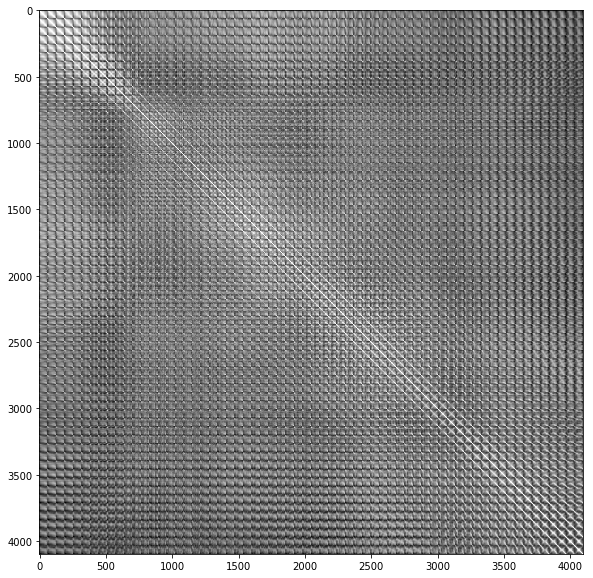

In [13]:
# One fun way to see it -- visualize the matrix. the brighter the color the higher the correlation
plt.figure(figsize = (10,10))
plt.imshow(cov_matrix, cmap = plt.cm.gray)
plt.show()

What does the principal component analysis do? It computes eigenvalues and eigenvectors of the covariance matrix:

$CX_{p} = \lambda_{p}X_{p}$

where $C$ -- covariance matrix, $X_{p}$ -- eigenvector, $\lambda_{p}$ -- eigenvalue.

What is the purpose of this? The eigenvector helps with transformation of the original data to the principal component, its eigenvalue is proportional to the amount of variance explained with the component

In [19]:
# CAREFUL! The complexity of np.linalg.eig is around O(N^3)
eig = np.linalg.eig(cov_matrix[:5,:5]) # let's compute the eigenvalues and eigenvectors for the first 5 pixels

In [22]:
eig[0]/5 # eigenvalues -- proportional to the amount of variance explained by each component

array([ 0.85742421,  0.11058056,  0.0229915 ,  0.00662338,  0.00238035])

In [24]:
eig[1] # these are eigenvectors

array([[-0.42426074, -0.59063634, -0.50465248, -0.41172273,  0.21670673],
       [-0.4563894 , -0.40262697,  0.15519656,  0.5915676 , -0.50553145],
       [-0.47093529,  0.02140642,  0.62051282,  0.02361194,  0.62623322],
       [-0.4579434 ,  0.38659534,  0.18436623, -0.58150978, -0.51835061],
       [-0.42452248,  0.58234529, -0.54973888,  0.37659133,  0.1913655 ]])

In [27]:
np.dot(eig[1][0],eig[1][1]) # they are orthogonal to each other, their dot product is ~0

7.2164496600635175e-16

In [29]:
# Suppose that we are fine with explaining 85% of the variance and use only the first component:
of.data[:,:5].shape # our data translates to this, i.e. all images, but only the first 5 pixels

(400, 5)

In [31]:
# To reduce dimensionality, we need to find the dot product b/w the first eigenvector and each image (use only 5 pixels there)
# one image:
np.dot(of.data[0,:5],eig[1][0])

-0.62674363764438001

In [34]:
# all images:
np.dot(of.data[:,:5],eig[1][0]).shape # this is the transformed data

(400,)

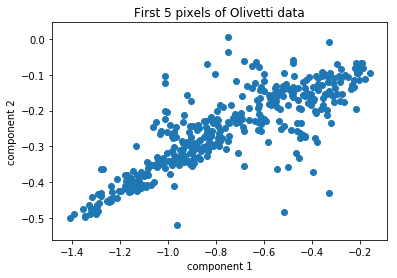

In [37]:
# We can also use 2 components, explaining ~97% of variance in data
plt.figure()
plt.scatter(np.dot(of.data[:,:5],eig[1][0]),np.dot(of.data[:,:5],eig[1][1]))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('First 5 pixels of Olivetti data')
plt.show()